# Example for offline calculation of condensation rates

This notebook shows how to use the functions in **microphysics_functions.py** to approximate condensation rates from hourly 3D standard WRF output. This approximation is based on the assumption that any change in supersaturation is balanced by condensation (saturated conditions are maintained).  

**Additional assumptions:** 

- changes in water vapor (qv) and temperature (T) from processes other than condensation and vertical velocity (e.g. mixing, radiation) can be neglected for deep convective systems
- deposition can be neglected (> 90 % of condensation+deposition comes from condensation in idealized MCS simulations)

In [1]:
import numpy as np
import datetime
import pandas as pd 
import xarray as xr
import wrf
from netCDF4 import Dataset
from pathlib import Path
import PE_Kukulies_mpfunctions as micro
import warnings
warnings.filterwarnings("ignore") 

#### Read in WRF model output 

In [2]:
# path = Path('/glade/campaign/mmm/c3we/prein/Idealized_MCSs/wrfout_files/WRF/19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5/4000')
# fname = path / 'wrfout_d01_0001-01-01_03:00:00'
fname = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/wrfout_d02_2013-11-02_15:00:00'

ds = xr.open_dataset(fname)
wrf_ds = Dataset(fname)

# get necessary variables
vertical_velocity = wrf.getvar(wrf_ds, 'wa')
temp = wrf.getvar(wrf_ds, 'tk')
pressure = wrf.getvar(wrf_ds, 'pres')
qcloud = ds.QCLOUD.squeeze()
# base_pressure = ds.PB.squeeze()

In [ ]:
ds.close()
wrf_ds.close()

#### Derive condensation rate for one timestep 

In [ ]:
# output of get_condensation_rate is in kg/kg/s
condensation_rate_t= micro.get_condensation_rate(vertical_velocity, temp, pressure)#, base_pressure)

#create a cloud mask, because equation is conditional for grid cells where qcloud > 0 
condensation_cloud = condensation_rate_t.where(qcloud > 0, 0) 
# moreover, we are only interested in positive values, as negative values are evaporation 
condensation_masked = condensation_cloud.where(condensation_cloud > 0, 0 ).data
# integrate over pressure levels to get kg/m2/s
condensation_rate = micro.pressure_integration(condensation_masked, -pressure.data)


#### Testing with post-processed WRF output

In [18]:
from read_functions import *

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
storm = 'haiyan'
datdir2 = 'post/d02/'

# datdir = main+storm+'/memb_01/ctl/'+datdir2
datdir = main+storm+'/memb_01/ctl/'

# # Get dimensions
# def get_nt(datdir, test_str):
#     datdir = main+storm+'/memb_01/'+test_str+'/'+datdir2
#     nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
#     # dp = (pres[1]-pres[0])*1e2 # Pa
#     # nt=np.min([nt,nt_data-time_neglect])
#     return nt_data, nz, pres
# nt_test, nz, pres = get_nt(datdir, 'ctl')
# t0=0
# t1=nt_test

# vertical_velocity = var_read_3d_hires(datdir, 'W', t0, t1, mask=True, drop=True)
# temp = var_read_3d_hires(datdir, 'T', t0, t1, mask=True, drop=True)
# qcloud = var_read_3d_hires(datdir, 'QCLOUD', t0, t1, mask=True, drop=True)

wrf_files = get_wrf_filelist(datdir)

#### Derive condensation rate for one timestep 

In [4]:
# output of get_condensation_rate is in kg/kg/s
condensation_rate_t= micro.get_condensation_rate(vertical_velocity, temp, pressure)#, base_pressure)

#create a cloud mask, because equation is conditional for grid cells where qcloud > 0 
condensation_cloud = condensation_rate_t.where(qcloud > 0, 0) 
# moreover, we are only interested in positive values, as negative values are evaporation 
condensation_masked = condensation_cloud.where(condensation_cloud > 0, 0 ).data
# integrate over pressure levels to get kg/m2/s
condensation_rate = micro.pressure_integration(condensation_masked, -pressure.data)


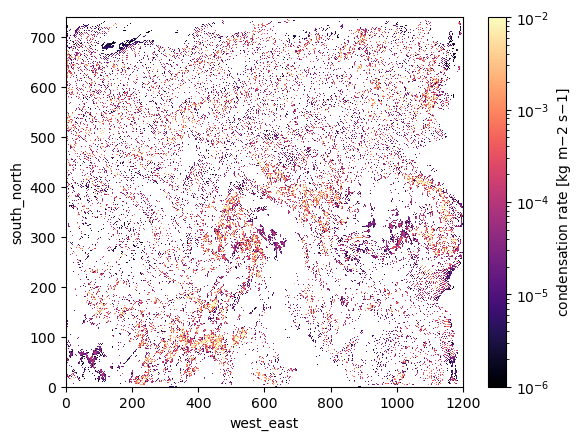

In [19]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
plt.pcolormesh(condensation_rate, norm = LogNorm(1e-6, 1e-2), cmap = 'magma')
plt.ylabel('south_north')
plt.xlabel('west_east')
plt.colorbar(label = 'condensation rate [kg m${-2}$ s${-1}$]') 
plt.show()